# Concentration de $\rm CO_2$ dans l'atmosphère depuis 1958

In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import fft, fftfreq

%matplotlib inline

## Chargement et vérification des données

Dans un premier temps, nous vérifions que le fichier de données local est présent, sinon nous le téléchargeons depuis l'URL.

In [2]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"
data_file = "weekly_in_situ_co2_mlo.csv"

if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Les données sont ensuite chargées à l'aide de pandas.

In [3]:
raw_data = pd.read_csv(data_file, skiprows=44, names=["Date", "CO2"])

new_data = raw_data.copy()
new_data.set_index("Date", drop=True, inplace=True)             
new_data.index = pd.to_datetime(new_data.index, format="%Y-%m-%d")

new_data.head()

CO2
Date              
1958-03-29  316.19
1958-04-05  317.31
1958-04-12  317.69
1958-04-19  317.58
1958-04-26  316.48

Nous vérifions la présence de données potentiellement manquantes mais également si il n'y a pas de semaines manquantes lors des relevés normalement hebdomadaires.

In [4]:
new_data[new_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [CO2]
Index: []

In [5]:
dates = new_data.index
missing_weeks = 0
delta_days = [0]
for dt1, dt2 in zip(dates[:-1], dates[1:]):
    delta = dt2 - dt1
    delta_days.append(delta.days)
    if delta > pd.Timedelta("7d"):
        print("From: {0:} To: {1:} Missing: {2:} days".format(dt1, dt2, delta.days))
        missing_weeks += (delta.days-7)/7
print("Total week missing: {0:}".format(missing_weeks))

From: 1958-05-03 00:00:00 To: 1958-05-17 00:00:00 Missing: 14 days
From: 1958-05-24 00:00:00 To: 1958-07-05 00:00:00 Missing: 42 days
From: 1958-08-16 00:00:00 To: 1958-08-30 00:00:00 Missing: 14 days
From: 1958-09-06 00:00:00 To: 1958-11-08 00:00:00 Missing: 63 days
From: 1959-01-31 00:00:00 To: 1959-02-14 00:00:00 Missing: 14 days
From: 1959-03-07 00:00:00 To: 1959-03-21 00:00:00 Missing: 14 days
From: 1959-05-23 00:00:00 To: 1959-06-06 00:00:00 Missing: 14 days
From: 1959-08-08 00:00:00 To: 1959-08-22 00:00:00 Missing: 14 days
From: 1962-08-18 00:00:00 To: 1962-09-15 00:00:00 Missing: 28 days
From: 1962-12-22 00:00:00 To: 1963-01-05 00:00:00 Missing: 14 days
From: 1963-02-09 00:00:00 To: 1963-02-23 00:00:00 Missing: 14 days
From: 1963-04-27 00:00:00 To: 1963-05-11 00:00:00 Missing: 14 days
From: 1963-11-16 00:00:00 To: 1963-11-30 00:00:00 Missing: 14 days
From: 1964-01-18 00:00:00 To: 1964-05-30 00:00:00 Missing: 133 days
From: 1964-06-06 00:00:00 To: 1964-06-27 00:00:00 Missing: 21

In [6]:
new_data["Delta_days"] = delta_days
new_data["Day_number"] = new_data["Delta_days"].cumsum()
new_data.head()

CO2  Delta_days  Day_number
Date                                      
1958-03-29  316.19           0           0
1958-04-05  317.31           7           7
1958-04-12  317.69           7          14
1958-04-19  317.58           7          21
1958-04-26  316.48           7          28

Aucune donnée n'est visiblement manquante dans le fichier, autrement dit toutes les lignes présentent bien une valeur.

En revanche nous voyons qu'il manque un certain nombre de semaines dans le fichier 72 au total.
Nous voyons également que l'année 1964 est celle présentant le moins de relevés hebdomadaires, en partie dû à un intervalle de 133 jours entre deux relevés.
Nous gardons donc cette information en mémoire pour la suite de l'analyse.

## Représentation des données

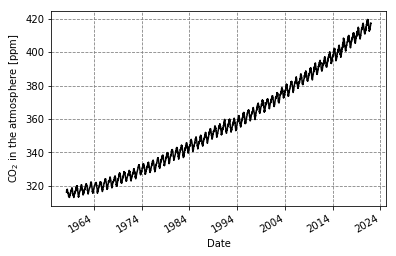

In [7]:
ax = new_data["CO2"].plot(color="black", linestyle="-")
ax.set_ylabel(r"$\rm CO_2$ in the atmosphere [ppm]")
ax.grid(linestyle="--", linewidth=0.8, color="gray")

Nous observons bien une oscillation périodique superposée à une évolution systématique plus lente.

## Analyses des données: composante systématique

Dans la suite, nous cherchons à séparer les deux contributions (systématique et oscillatoire). L'augmentation systématique de la teneur en $\rm CO_2$ est estimée à partir d'une fonction polyomiale de degré 2 et d'équation: $y = a_2 x^2 + a_1 x + a_0$.

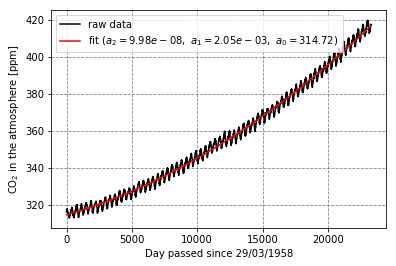

In [8]:
x = new_data["Day_number"]
y = new_data["CO2"]

coeff = np.polyfit(x, y, 2)
y_fit = np.polyval(coeff, x)
new_data["Incr_trend"] = y_fit

plt.figure()
plt.plot(x, y, color="black", linestyle="-", label="raw data")
plt.plot(x, y_fit, color="red", linestyle="-", label=r"fit ($a_2={0:.2e},\ a_1={1:.2e},\ a_0={2:.2f}$)".format(*coeff))

plt.xlabel("Day passed since {:%d/%m/%Y}".format(new_data.index[0]))
plt.ylabel(r"$\rm CO_2$ in the atmosphere [ppm]")
plt.grid(linestyle="--", linewidth=0.8, color="gray")
plt.legend()

plt.show()

Nous pouvons dès à présent réaliser une estimation de la teneur moyenne en $\rm CO_2$ dans l'atmosphère pour 2025. Notons que cette méthode n'est pas la plus adaptée mais permet d'obtenir un ordre de grandeur satisfaisant.

In [9]:
days_to_2025 = (pd.to_datetime("2025-01-01") - new_data.index[0]).days
CO2_2025 = np.polyval(coeff, days_to_2025)
CO2_2025

424.04528179868464

## Analyses des données: composante oscillatoire

A présent nous pouvons essayer de déterminer la période d'oscillation.
De fait, nous soustrayons la contribution systématique des données brutes afin de ne garder que la composante oscillatoire.

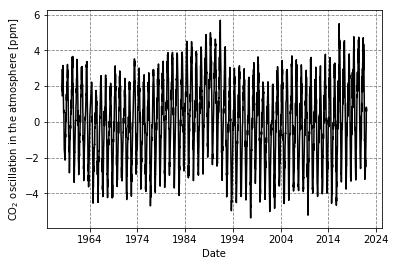

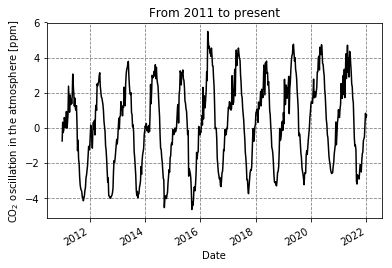

In [10]:
y_new = y - y_fit
new_data["CO2_osc"] = y_new

plt.figure()
plt.plot(new_data.index, y_new, color="black", linestyle="-")
plt.xlabel("Date")
plt.ylabel(r"$\rm CO_2$ oscillation in the atmosphere [ppm]")
plt.grid(linestyle="--", linewidth=0.8, color="gray")

plt.figure()
new_data["CO2_osc"]["2011":].plot(color="black", linestyle="-")
plt.xlabel("Date")
plt.ylabel(r"$\rm CO_2$ oscillation in the atmosphere [ppm]")
plt.title("From 2011 to present")
plt.grid(linestyle="--", linewidth=0.8, color="gray")
plt.xlim()

plt.show()

Nous réalisons par la suite une transformée de Fourier au signal précédemment obtenu afin de déterminer les fréquences qui lui sont associées.

Note: l'ensemble des données est pris en compte dans l'analyse, ce qui n'est pas optimal sachant qu'il manque des relevés hebdomadaires. En effet, il vaudrait mieux se placer sur une plage de donnée dont l'incrément est uniforme. Cependant par manque de temps, l'analyse est tout de même poursuivie ainsi. A prendre donc avec des pincettes !

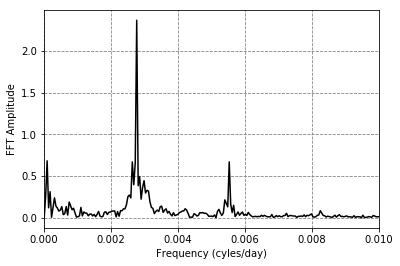

In [11]:
N = len(y_new)
T = 7 # time step in day

X = fft(y_new)[0:N//2]
freq = fftfreq(N, T)[:N//2] # [cycles/day]
amp = 2.0/N * np.abs(X)

plt.plot(freq, amp, color="black", linestyle="-")
plt.xlabel('Frequency (cyles/day)')
plt.ylabel('FFT Amplitude')
plt.grid(linestyle="--", linewidth=0.8, color="gray")
plt.xlim(left=0, right=1e-2)

plt.show()

Nous nous intéressons maintenant aux fréquences de plus fortes amplitudes. Le bloc ci-dessous permet d'obtenir les trois fréquences de plus fortes amplitudes. Ces dernières sont représentées en rouge sur le graphique ci-dessous.

[2.76327909e-03 8.77231458e-05 5.52655818e-03]
[  361.88888889 11399.5          180.94444444]


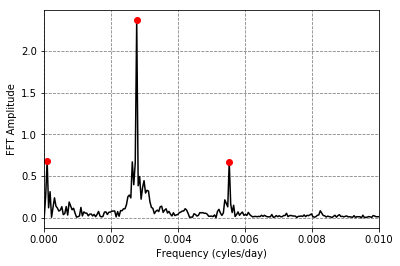

In [12]:
_sort_id = np.argsort(amp)
ampMax = amp[_sort_id][::-1][:3:]
freqMax = freq[_sort_id][::-1][:3:]

print(freqMax)
print(1/freqMax)

plt.plot(freq, amp, color="black", linestyle="-")
plt.plot(freqMax, ampMax, color="red", linestyle="", marker="o")
plt.xlabel('Frequency (cyles/day)')
plt.ylabel('FFT Amplitude')
plt.grid(linestyle="--", linewidth=0.8, color="gray")
plt.xlim(left=0, right=1e-2)

plt.show()

Si l'on s'intéresse à la fréquence dont l'amplitude est maximale, cela correspond à un cycle tous les 362 jour environs. Cela semble cohérent avec les observations graphiques (cf. graphique zoomé à partir de 2011).
La seconde fréquence a peu de sens, dans la mesure où cette dernière est obtenu à très basse fréquence et provient probablement d'un artefact de calcul.
La troisième fréquence quant à elle correspond à période de 181 jours environ. Par la suite, il serait intéressant de creuser davantage l'analyse ainsi que l'interprétation de ces résultats.

## Conclusion

Il a été possible de:
1. charger les données et conduire des analyses
1. estimer une concentration potentielle de $\rm CO_2$ dans l'atmosphère à l'horizon 2025 d'environ 424 ppm à partir d'une méthode de régression polynomiale.
1. estimer la période d'oscillation des cycles de concentration en $\rm CO_2$ dans l'atmosphère à environ 362 jours par application d'une transformée de Fourier.